In [97]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from imports import *
import numpy as np
import pandas as pd
import os, h5py, json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.cluster.hierarchy as sch
from scipy import signal
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats.stats import pearsonr, spearmanr
from target import build_tgt_matrix

%matplotlib inline

In [86]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [87]:
source = '/home/sobolev/nevermind/Andrey/data'
report = '/home/sobolev/nevermind/Andrey/analysis/PSTH'

In [135]:
selected_sessions = [
# frequency
'009266_hippoSIT_2023-04-17_17-04-17',  # ch17, 20 + 55 correction, 5067 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-18_10-10-37',  # ch17, 10 + 55 correction, 5682 events
'009266_hippoSIT_2023-04-18_17-03-10',  # ch17, 6 + 55 correction, 5494 events: FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-19_10-33-51',  # ch17, 4 + 55 correction, 6424 events: very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-24_16-56-55',  # ch17, 5 + 55* correction, 6165 events, frequency
'009266_hippoSIT_2023-05-02_12-22-14',  # ch20, 10 + 55 correction, 5976 events, FIXME very weird 1-2nd in target, find out
    
# duration
'009266_hippoSIT_2023-04-20_08-57-39',  # ch1, 1 + 55 correction, 6424 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-26_08-20-17',  # ch17, 12 + 55* correction, 6095 events, duration - showcase for N2 
'009266_hippoSIT_2023-05-04_19-47-15',  # ch20, 2 + 55 correction, 5678 events, duration

# COMA
'009266_hippoSIT_2023-05-04_09-11-06',  # ch17, 5 + 55* correction, 4487 events, COMA session with baseline AEPs

# Old PPC sessions
'008229_hippoSIT_2022-05-17_21-44-43',  # chs: 0, 31, 54, 56
'008229_hippoSIT_2022-05-16_20-36-44',  # chs: 0, 56
'008229_hippoSIT_2022-05-20_15-54-39',  # chs: 0, 56
'008229_hippoSIT_2022-05-18_14-36-18',  # chs: 0, 56
]

session = selected_sessions[6]

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5name      = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, session)
if not os.path.exists(report_path):
    os.makedirs(report_path)
#moseq_file  = os.path.join(sessionpath, 'moseq.h5')

## Reading data

In [136]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])
    
with h5py.File(aeps_file, 'r') as f:
    aeps_A1 = np.array(f['A1']['aeps'])
    aeps_PPC = np.array(f['PPC']['aeps'])
    aeps_events = np.array(f['aeps_events'])
    
# TODO find better way. Remove outliers
aeps_A1[aeps_A1 > 5000]    =  5000
aeps_A1[aeps_A1 < -5000]   = -5000
aeps_PPC[aeps_PPC > 1500]  =  1500
aeps_PPC[aeps_PPC < -1500] = -1500

In [137]:
# # load metrics
area = 'A1'

AEP_metrics_lims = {}
AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_file, 'r') as f:
    grp = f[area]
    
    for metric_name in grp['raw']:
        AEP_metrics_raw[metric_name]  = np.array(grp['raw'][metric_name])
        AEP_metrics_norm[metric_name] = np.array(grp['norm'][metric_name])
        AEP_metrics_lims[metric_name] = [int(x) for x in grp['raw'][metric_name].attrs['limits'].split(',')]

#with h5py.File(moseq_file, 'r') as f:
#    moseq_matrix = np.array(f['moseq'])
#    moseq_headers = f['moseq'].attrs['headers'].split(', ')
#moseq_df = pd.DataFrame(moseq_matrix, columns=moseq_headers)

In [138]:
tgt_matrix = build_tgt_matrix(tl, trials, aeps_events)

aeps_A1.shape, aeps_PPC.shape, tgt_matrix.shape

((5989, 200), (5989, 200), (43, 5))

In [298]:
# speed - from MoSeq / DLC
width = 100  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)

x_smooth = np.convolve(moseq_df['centroid_x'], kernel, 'same') / kernel.sum()
y_smooth = np.convolve(moseq_df['centroid_x'], kernel, 'same') / kernel.sum()

# speed
dx = np.sqrt(np.square(np.diff(x_smooth)) + np.square(np.diff(y_smooth)))
dt = np.diff(tl[:, 0])
speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])

speed[:10] = np.zeros(10)

In [95]:
speed = tl[:, 3]

## AEPs timeline

In [51]:
def to_normed(data):
    normed = data - data.min() 
    return normed/(normed.max() - normed.min())

In [52]:
min_dur = 0
idxs_target = np.where(tl[:, 6] == 2)[0]
idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]
idxs_tgt_start -= 25  # FIXME weird shift for 250 ms

idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_to_idx = np.where(np.diff(idxs_backgr) > 5)[0] + 1
idxs_bgr_start = idxs_backgr[:-1][idxs_to_idx[:-1]]
idxs_bgr_start -= 25  # FIXME weird shift for 250 ms

In [53]:
# normalization for plotting
AEP_ratios = {}

for m_name in AEP_metrics_norm.keys():
    m_raw  = AEP_metrics_raw[m_name]
    m_norm = AEP_metrics_norm[m_name]
    AEP_ratios[m_name] = (m_raw.max() - m_raw.min()) / (m_norm.max() - m_norm.min())
   
    
#N1_ratio = (aeps_N1.max() - aeps_N1.min()) / (aeps_N1_smooth.max() - aeps_N1_smooth.min())
#P1_ratio = (aeps_P1.max() - aeps_P1.min()) / (aeps_P1_smooth.max() - aeps_P1_smooth.min())
#N2_ratio = (aeps_N2.max() - aeps_N2.min()) / (aeps_N2_smooth.max() - aeps_N2_smooth.min())

In [54]:
AEP_ratios

{'N1': 39633.6222942053,
 'P1': 13553.363144541947,
 'P2': 25765.056408413046,
 'P3': 60226.7176122798}

In [74]:
# for 2023-05-02_12-22-14: 2: 2, 9, 12, 18; 4: 6, 7, 8, 10; 5: 3, 6: 5, 7, 8, 9
unit_id = '3-15'

with h5py.File(h5name, 'r') as f:
    i_rate = np.array(f['units'][str(unit_id)]['inst_rate'])
    s_times = np.array(f['units'][str(unit_id)]['spike_times'])

(900.0, 1100.0)

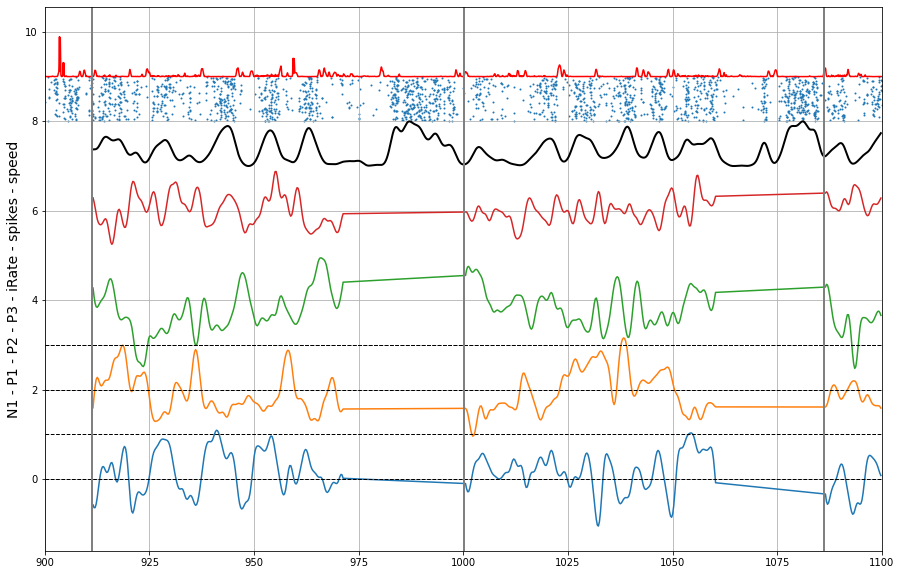

In [84]:
t_start, t_end = 900, 1100  # secs

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ev_idxs  = np.where((aeps_events[:, 0] > t_start) & (aeps_events[:, 0] < t_end))[0]

#normed   = [N1_norm, P1_norm, N2_norm]
#smoothed = [N1_smooth_norm, P1_smooth_norm, N2_smooth_norm]
#ratios   = [N1_ratio, P1_ratio, N2_ratio]

y_label = ''
for i, (m_name, m_vals) in enumerate(AEP_metrics_norm.items()):  # AEP N1, P1, N2, N3 metrics
    #vals = ratios[i] * (norm[ev_idxs] - norm[ev_idxs].mean()) + norm[ev_idxs].mean()
    #ax.plot(aeps_events[ev_idxs][:, 0], i + vals)
    ax.plot(aeps_events[ev_idxs][:, 0], 2*i + m_vals[ev_idxs])
    #ax.axhline(i + smoothed[i].mean(), lw=1, ls='--', color='black')
    ax.axhline(i, lw=1, ls='--', color='black')
    y_label += '%s - ' % m_name

# selected unit firing rate
idxs_tl = np.where((tl[:, 0] > aeps_events[ev_idxs[0]][0]) & (tl[:, 0] < aeps_events[ev_idxs[-1]][0]))[0]
ax.plot(tl[idxs_tl][:, 0], 7 + to_normed(i_rate[idxs_tl]), color='black', lw=2)
ax.axhline(3, lw=1, ls='--', color='black')
ax.grid()
y_label += '%s - ' % 'iRate'

ax.scatter(s_times, 8 + np.random.rand(len(s_times)), s=1)  # spiking
ax.plot(tl[:, 0], 9 + to_normed(speed), color='red')  # speed
y_label += '%s - %s' % ('spikes', 'speed')
ax.set_ylabel(y_label, fontsize=14)
# syllables
#colors = [plt.cm.tab20(2*i) for i in range(15)]
#syls = moseq_df['syllables_reindexed'].unique()
#for i in range(len(syls)):
#    idxs = np.where(moseq_df['syllables_reindexed'] == i + 1)[0]
#    if len(idxs) > 0:
#        ax.scatter(tl[idxs][:, 0], np.ones(len(idxs)) * i * 0.1 + 5.1, s=5, color=colors[i])

# events
sel_events = aeps_events[ev_idxs]
tgt_events = sel_events[sel_events[:, 1] == 2]
for t_event in tgt_events[:, 0]:
    ax.axvline(t_event, color='green', ls='--', alpha=0.2)
for t_event in tl[idxs_tgt_start][:, 0]:
    ax.axvline(t_event, color='green', lw=2)
for t_event in tl[idxs_bgr_start][:, 0]:
    ax.axvline(t_event, color='gray', lw=2)  
ax.set_xlim(t_start, t_end)

## Another way

In [139]:
unit_id = '3-15'

with h5py.File(h5name, 'r') as f:
    i_rate = np.array(f['units'][str(unit_id)]['inst_rate'])
    s_times = np.array(f['units'][str(unit_id)]['spike_times'])

In [140]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

In [147]:
window_l = 30  # in AEP events, 10 sec is ~40 events
inst_corrs = np.zeros(len(AEP_metrics_norm['P1']) - window_l)
#metric1, metric2 = AEP_metrics_norm['N1'], AEP_metrics_norm['P3']
metric1, metric2 = AEP_metrics_norm['N1'], i_rate[aeps_tl_idxs]
for i in range(len(inst_corrs)):
    inst_corrs[i] = pearsonr(metric1[i:i + window_l], metric2[i:i + window_l])[0]

Text(0.5, 0, 'Time, s')

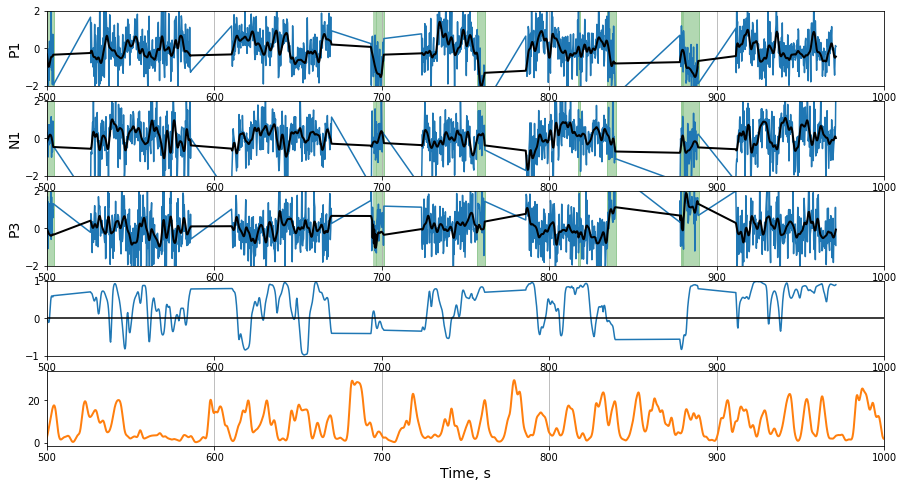

In [149]:
t_start, t_end = 500, 1000  # secs
aeps_events_idxs = np.where((aeps_events[:, 0] > t_start) & (aeps_events[:, 0] < t_end))[0]
aeps_events_times = aeps_events[aeps_events_idxs][:, 0]

fig, axes = plt.subplots(5, 1, figsize=(15, 4*2))

metric_names = ['P1', 'N1', 'P3']  # AEP_metrics_raw.keys()
for i, metric in enumerate(metric_names):
    axes[i].plot(aeps_events_times, stats.zscore(AEP_metrics_raw[metric][aeps_events_idxs]))
    axes[i].plot(aeps_events_times, AEP_metrics_norm[metric][aeps_events_idxs], lw=2, color='black')
    axes[i].set_xlim(t_start, t_end)
    axes[i].set_ylim(-2, 2)
    axes[i].grid(axis='x')
    axes[i].set_ylabel(metric, fontsize=14)
    for tgt_event in tgt_matrix:
        axes[i].axvspan(tl[tgt_event[0]][0], tl[tgt_event[1]][0], alpha=0.3, color='green')

axes[3].plot(aeps_events_times, inst_corrs[aeps_events_idxs])
axes[3].axhline(0, color='black')
axes[3].set_xlim(t_start, t_end)
axes[3].set_ylim(-1, 1)
    
# unit
axes[4].plot(tl[:, 0], i_rate, lw=2, color='tab:orange')
axes[4].set_xlim(t_start, t_end)
axes[4].grid(axis='x')
axes[4].set_xlabel('Time, s', fontsize=14)

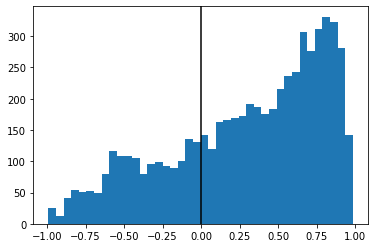

In [151]:
plt.hist(inst_corrs, bins=40)
plt.axvline(0, color='black')

## AEP events - units corr matrix

In [28]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
    
aeps_tl_idxs = np.array(aeps_tl_idxs)

### Read units

In [32]:
# get available units
unit_names = []
with h5py.File(h5name, 'r') as f:
    unit_names = [x for x in f['units']]
            
print(unit_names), len(unit_names)

['1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-10', '2-11', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '3-10', '3-11', '3-12', '3-13', '3-14', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '3-8', '3-9', '4-2', '4-3', '4-4', '4-5', '4-6', '5-2', '5-3', '5-4']


(None, 48)

In [33]:
# read single units
single_units = {}
spike_times = {}

with h5py.File(h5name, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        #single_units[unit_name] = instantaneous_rate(unit_times, tl[:, 0], k_width=50)

In [39]:
# metrics / units
metrics = [
    AEP_metrics_raw['P1'],
    AEP_metrics_raw['N1'],
    AEP_metrics_raw['P3'],
    speed[aeps_tl_idxs]
]

corr_pearson = np.zeros((4, len(single_units)))  # N1, P1, P3, speed X units firing rate
for i, metric in enumerate(metrics):
    for j, (unit_name, data) in enumerate(single_units.items()):
        corr_pearson[i, j]  = pearsonr(metric, data[aeps_tl_idxs])[0]

Text(0.5, 1.0, 'Metric / Units correlations')

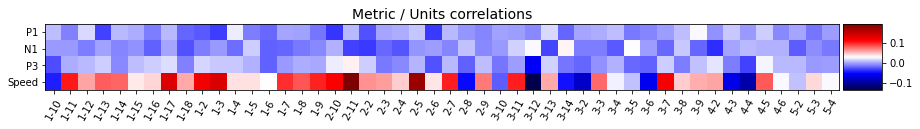

In [40]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
im = ax.imshow(corr_pearson, cmap='seismic')
ax.set_xticks(range(corr_pearson.shape[1]))
ax.set_xticklabels(single_units.keys(), rotation=60)
ax.set_yticks(range(corr_pearson.shape[0]))
_ = ax.set_yticklabels(['P1', 'N1', 'P3', 'Speed'])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('Metric / Units correlations', fontsize=14)

In [41]:
session

'009266_hippoSIT_2023-04-18_17-03-10'